# k-means with text data

### Due: Wednesday, 16th May, at 11:59 pm on Canvas

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

Copyright ©2018 Emily Fox.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

## Import necessary packages

In [2]:
import turicreate as tc
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix

%matplotlib inline

## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [3]:
wiki, _ = tc.SFrame('/data/people_wiki.gl/').random_split(0.1, seed=0) # Using 10% of the data, due to limited resources

In [4]:
wiki

URI,name,text
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...
<http://dbpedia.org/resource/Ian_Mitchell_(aut ...,Ian Mitchell (author),ian mitchell is ascottish author who grew ...
<http://dbpedia.org/resource/Ted_Hill_(mathema ...,Ted Hill (mathematician),theodore preston hillborn december 28 1943 is ...
<http://dbpedia.org/resource/Steven_Weil> ...,Steven Weil,steven weil is anamerican rabbi who grew ...
<http://dbpedia.org/resource/Rob_Sheffield> ...,Rob Sheffield,rob sheffield bornfebruary 2 1966 is an ...
<http://dbpedia.org/resource/Michel_Che> ...,Michel Che,professor michel che bornin lyon france completed ...
<http://dbpedia.org/resource/Vincent_Fang_(lyr ...,Vincent Fang (lyricist),for a hong kongentrepreneur please r ...
<http://dbpedia.org/resource/Susan_Christie> ...,Susan Christie,susan christie is anamerican singersongwr ...
<http://dbpedia.org/resource/Quintin_E._Primo_ ...,Quintin E. Primo III,quintin e primo iii bornmarch 14 1955 is the ...


In [5]:
wiki['tf_idf'] = tc.text_analytics.tf_idf(wiki['text'])

In [6]:
wiki

URI,name,text,tf_idf
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':3.848936004850463, ..."
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':5.827907016166664, ..."
<http://dbpedia.org/resource/Ian_Mitchell_(aut ...,Ian Mitchell (author),ian mitchell is ascottish author who grew ...,"{'office':2.667158932916311, ..."
<http://dbpedia.org/resource/Ted_Hill_(mathema ...,Ted Hill (mathematician),theodore preston hillborn december 28 1943 is ...,"{'operations':3.755845581784451, ..."
<http://dbpedia.org/resource/Steven_Weil> ...,Steven Weil,steven weil is anamerican rabbi who grew ...,"{'rabbi':24.088252122430486, ..."
<http://dbpedia.org/resource/Rob_Sheffield> ...,Rob Sheffield,rob sheffield bornfebruary 2 1966 is an ...,"{'gq': 6.096171002761344,'true': ..."
<http://dbpedia.org/resource/Michel_Che> ...,Michel Che,professor michel che bornin lyon france completed ...,"{'particularly':3.6706877734441443, ..."
<http://dbpedia.org/resource/Vincent_Fang_(lyr ...,Vincent Fang (lyricist),for a hong kongentrepreneur please r ...,"{'chinese':22.624627392006758, ..."
<http://dbpedia.org/resource/Susan_Christie> ...,Susan Christie,susan christie is anamerican singersongwr ...,"{'weavers':7.967973179662935, ..."
<http://dbpedia.org/resource/Quintin_E._Primo_ ...,Quintin E. Primo III,quintin e primo iii bornmarch 14 1955 is the ...,"{'limited':15.083084928004507, ..."


For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

In [7]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert x[column_name].dtype() == {}, \
    'The chosen column must be dict type, representing sparse data.'
        
    # Create triples of (row_id, feature_id, count).
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    keys = x['feature'].unique()
    encoding = {k:i for i, k in enumerate(keys)}
    # Apply the mapping
    x['feature_id'] = x['feature'].apply(lambda key: encoding[key])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, {i:k for i, k in enumerate(keys)}

In [8]:
# The conversion will take about a minute or two.
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 24)"

Note that increasing the degree of parallelism also increases the memory footprint.

In [9]:
tf_idf

<5774x110013 sparse matrix of type '<type 'numpy.float64'>'
	with 1017753 stored elements in Compressed Sparse Row format>

The above matrix contains a TF-IDF score for each of the 5774 pages in the data set and each of the 110013 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [10]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [11]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [12]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[1.41068657 1.41126417]
 [1.40838656 1.41044618]
 [1.41150978 1.41152872]
 ...
 [1.40698593 1.39992816]
 [1.40540087 1.39464441]
 [1.41090819 1.4060136 ]]


In [13]:
dist.shape


(5774, 2)

More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute pairwise distances from each of the centroids (which we're initializing as the first 3 rows) to all data points in `tf_idf`, and save it `distances`. Then find the distance between row 430 of `tf_idf` and the second centroid by extracting it from `distances` and save it to `dist`.

In [14]:
# Students should write code here
queries = tf_idf[0:3,:]
distances = pairwise_distances(tf_idf, queries, metric='euclidean')
dist = distances[430,1]

In [15]:
distances.shape

(5774, 3)

In [16]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint. Following the theme of this case study, we will judge whether the clustering makes sense in the context of document analysis.. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [17]:
# Students should write code here
closest_cluster = np.argmin(distances, axis = 1)
closest_cluster.shape

(5774,)

In [23]:
a=[[4, 1, 2], 
   [3, 4, 5],
   [5, 5, 0]]
np.argmin(a, axis = 0)   
# returns index of the smallest column down each row 

array([1, 0, 2])

In [24]:
np.argmin(a, axis = 1)    #returns index of the smallest row in each col

array([1, 0, 2])

In [25]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [26]:
# Students should write code here
cluster_assignment = closest_cluster

In [27]:
if len(cluster_assignment)==5774 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([1476, 1562, 2736])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks the function `assign_clusters(data, centroids)`. 

Parameters:  
 - `data` - is an `np.array` of `float` values of length `N`.  
 - `centroids` - is an `np.array` of `float` values of length `k`.

Returns  
-  A `np.array` of length `N` where the `i`th index represents which centroid `data[i]` was assigned to. The assignments range between the values `0, ..., k-1`.

In [28]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    cluster_assignment = np.argmin(distances_from_centroids, axis = 1)
    
    return cluster_assignment

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [29]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 3, 3, 0, 3, 0, 2, 3, 0, 0])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [30]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [31]:
cluster_assignment = assign_clusters(data, centroids)
print cluster_assignment

[0 1 0]


The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [32]:
cluster_assignment==1

array([False,  True, False])

Likewise for cluster 0:

In [33]:
cluster_assignment==0

array([ True, False,  True])

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [34]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [35]:
data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [36]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

Now we are ready to fill in the blanks the function `revise_centroids(data, k, cluster_assignment)`. 

Parameters:  
 - `data` - is an `np.array` of `float` values of length `N`.
 - `k` - number of centroids
 - `cluster_assignment` - `np.array` of length `N` where the `i`th index represents which centroid `data[i]` was assigned to. The assignments range between the values `0, ..., k-1`.

Returns  
-  A `np.array` of length `k` for the new centroids.

In [40]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i,:]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 100 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [41]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [42]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i,:]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [43]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

Now we are ready to fill in the blanks the function `kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)`. 

Parameters:  
 - `data` - is an `np.array` of `float` values of length `N`.
 - `k` - number of centroids
 - `initial_centroids` - is an `np.array` of `float` values of length `k`.
 - `maxiter` - maximum number of iterations to run the algorithm
 - `record_heterogeneity` - if provided an empty list, it will compute the heterogeneity at each iteration and append it to the list. Defaults to `None` and won't record heterogeneity.
 - `verbose` - set to True to display progress. Defaults to `False` and won't display progress.

Returns  
- `centroids` - A `np.array` of length `k` for the centroids upon termination of the algorithm.
- `cluster_assignment` - A `np.array` of length `N` where the `i`th index represents which centroid `data[i]` was assigned to. The assignments range between the values `0, ..., k-1` upon termination of the algorithm.

In [50]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)

    
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment-cluster_assignment))
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed)) 
                
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [51]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
     1901 elements changed their cluster assignment.
2
      881 elements changed their cluster assignment.
3
      654 elements changed their cluster assignment.
4
      251 elements changed their cluster assignment.
5
      140 elements changed their cluster assignment.
6
       75 elements changed their cluster assignment.
7
       37 elements changed their cluster assignment.
8
       29 elements changed their cluster assignment.
9
       25 elements changed their cluster assignment.
10
       21 elements changed their cluster assignment.
11
       18 elements changed their cluster assignment.
12
       13 elements changed their cluster assignment.
13
       17 elements changed their cluster assignment.
14
       18 elements changed their cluster assignment.
15
       24 elements changed their cluster assignment.
16
       26 elements changed their cluster assignment.
17
       16 elements changed their cluster assignment.
18
       19 elements changed their cluster assignment.

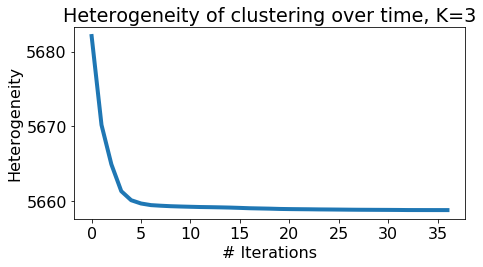

In [52]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

**Quiz Question**. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.

**Quiz Question**. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.

**Quiz Question**. Which of the cluster contains the greatest number of data points in the end? Hint: Use [`np.bincount()`](http://docs.scipy.org/doc/numpy-1.11.0/reference/generated/numpy.bincount.html) to count occurrences of each cluster label.
 1. Cluster #0
 2. Cluster #1
 3. Cluster #2

In [53]:
np.bincount(cluster_assignment)

array([1126, 1919, 2729])

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [54]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=5597.40178
seed=020000, heterogeneity=5604.30082
seed=040000, heterogeneity=5599.33500
seed=060000, heterogeneity=5600.55323
seed=080000, heterogeneity=5593.77701
seed=100000, heterogeneity=5593.91355
seed=120000, heterogeneity=5598.51115
17.3989219666


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [55]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [56]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=5594.15498
seed=020000, heterogeneity=5593.14744
seed=040000, heterogeneity=5595.40313
seed=060000, heterogeneity=5595.68053
seed=080000, heterogeneity=5598.66627
seed=100000, heterogeneity=5599.06461
seed=120000, heterogeneity=5595.91635
16.6025929451


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

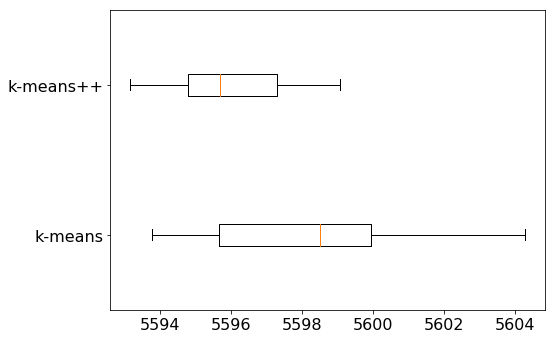

In [57]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* Random initialization results in a worse clustering than k-means++ on average.
* The best result of k-means++ is better than the best result of random initialization.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

Now we are ready to fill in the blanks the function `kmeans_multiple_runs(data, k, maxiter, verbose=False)`. 

Parameters:  
 - `data` - is an `np.array` of `float` values of length `N`.
 - `k` - number of centroids
 - `maxiter` - maximum number of iterations to run the algorithm
 - `verbose` - set to True to display progress. Defaults to `False` and won't display progress.

Returns  
- `final_centroids` - A `np.array` of length `k` for the centroids upon termination of the algorithm.
- `final_cluster_assignment` - A `np.array` of length `N` where the `i`th index represents which centroid `data[i]` was assigned to. The assignments range between the values `0, ..., k-1` upon termination of the algorithm.

In [64]:
def kmeans_multiple_runs(data, k, maxiter, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]
    num_runs = len(seed_list)
    
    for seed in seed_list:
        
        # Use k-means++ initialization: Fill in the blank
        # Set record_heterogeneity=None because we will compute that once
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means: Fill in the blank 
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # Fill in the blank on the right
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.


**IMPORTANT: The code block below will take about 5-6 minutes to finish. **

seed=000000, heterogeneity=5675.70889
seed=020000, heterogeneity=5679.97381
seed=040000, heterogeneity=5679.17086
seed=060000, heterogeneity=5679.19746
seed=080000, heterogeneity=5679.63205
seed=100000, heterogeneity=5679.55879
seed=120000, heterogeneity=5679.18986
seed=000000, heterogeneity=5594.15498
seed=020000, heterogeneity=5593.14744
seed=040000, heterogeneity=5595.40313
seed=060000, heterogeneity=5595.68053
seed=080000, heterogeneity=5598.66627
seed=100000, heterogeneity=5599.06461
seed=120000, heterogeneity=5595.91635
seed=000000, heterogeneity=5535.68066
seed=020000, heterogeneity=5531.99017
seed=040000, heterogeneity=5533.56981
seed=060000, heterogeneity=5535.05054
seed=080000, heterogeneity=5538.11343
seed=100000, heterogeneity=5521.55550
seed=120000, heterogeneity=5535.61407
seed=000000, heterogeneity=5475.14912
seed=020000, heterogeneity=5483.48702
seed=040000, heterogeneity=5466.64871
seed=060000, heterogeneity=5464.76777
seed=080000, heterogeneity=5466.33501
seed=100000,

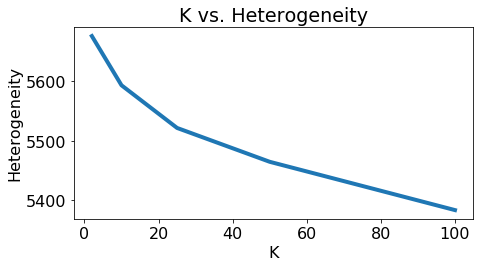

In [65]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

start = time.time()
centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                               verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

end = time.time()
print(end-start)

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [66]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(wiki[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

In [67]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0     he:0.016 his:0.011 music:0.010 university:0.010 season:0.010 

* Justin Knoedler                                    0.98055
  justin joseph knoedler born july 17 1980 in springfield illinois is a former major league 
  baseball catcherknoedler was originally drafted by the st louis cardinals

* James A. Joseph                                    0.98149
  james a joseph born 1935 is an american former diplomatjoseph is professor of the practice
   of public policy studies at duke university and founder of

* Sol Campbell                                       0.98223
  sulzeer jeremiah sol campbell born 18 september 1974 is a former england international foo
  tballer a central defender he had a 19year career playing in the

* Mark McCall                                        0.98269
  mark mccall born 29 november 1967 in bangor county down northern ireland is an irish forme
  r rugby union player and former coach of ulster he

* Kevin Houston                              

Both clusters have mixed content, although clearly cluster 0 are all men and cluster 1 are all women:
* Cluster 0: men, football, rugby, basketball, etc..
* Cluster 1: women, policitians, artists, singers, etc..

Top words of cluster 1 are mostly related to women, whereas top words of cluster 0 are mostly related to men.

It would be better if we sub-divided into more categories. So let us use more clusters. How about `K=10`?

In [68]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0     art:0.058 book:0.028 poetry:0.027 museum:0.027 gallery:0.026 

* Thomas Lawson (artist)                             0.95479
  thomas lawson born 1951 glasgow scotland is an artist writer and dean of the school of art
   at california institute for the arts he has

* Will Maclean                                       0.95615
  a noted and established scottish artist and professor of art will maclean was born in inve
  rness in 1941 he was a midshipman 195759 before attending

* Steve Roden                                        0.95696
  steve roden is an american sound and visual artist who pioneered the lowercase style of mu
  sic where quiet usually unheard sounds are amplified to form

* Kerri Sakamoto                                     0.95725
  kerri sakamoto born 1960 is a canadian novelist her novels commonly deal with the experien
  ce of japanese canadianssakamotos debut novel the electrical field 1998 won

* Alberto Blanco (poet)                              0.


* Judy Spence                                        0.95517
  judith caroline spence born 19 may 1957 is an australian politician and former member of t
  he legislative assembly of queensland for the australian labor party

* Ross Ainsworth                                     0.95533
  ross andrew ainsworth born 25 september 1947 is an australian politician he was a national
   party of western australia member of the western australian legislative

* Joseph A. Day                                      0.95673
  joseph a day born january 24 1945 is a canadian politician he has been a canadian senator 
  since october 4 2001day studied at college militaire

* Bernard Th%C3%A9riault                             0.95741
  bernard thriault born november 12 1955 is a political figure in the province of new brunsw
  ick canada he became chief of staff to premier of
Cluster 5     film:0.107 theatre:0.045 films:0.036 festival:0.032 directed:0.031 

* Paul Popplewell                           


* Jonathan Klein (CNN)                               0.98290
  jonathan klein is an american media executive he is the former president of cnnus who was 
  responsible for management oversight of all programming editorial tone

* David McGuffin                                     0.98390
  david mcguffin is a broadcast journalist working with national public radio in washington 
  dc as an editor on its flagship morning edition program prior to

* Ian Collins (radio presenter)                      0.98458
  ian collins is a british radio and television presenter and journalist he was the presente
  r of the late show 10pm mon thurs on national radio

* Tom Gross                                          0.98478
  tom gross is a britishborn journalist international affairs commentator and human rights c
  ampaigner specializing in the middle east in 2014 former pentagon official michael rubin

* Malachi O'Doherty                                  0.98531
  malachi odoherty born co donega

We no longer have the clear split between men and women. Cluters 0 and 2 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, poets, writers
* Cluster 1: composers, songwriters, singers, music producers
* Cluster 2: singers, songwriters, members of bands
* Cluster 3: female figures from various fields
* Cluster 4: politicians
* Cluster 5: film directors
* Cluster 6: soccer (football) players, baseball players
* Cluster 7: professors, researchers, scholars, lawyers, judges
* Cluster 8: track and field athletes
* Cluster 9: journalists, tv personalities, media executives

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of film directors. Increasing the number of clusters may split larger clusters. Another way to look at the size of cluster is to count the number of articles in each cluster.

In [69]:
np.bincount(cluster_assignment[10])

array([ 461,  189,  483,  674,  465,  314,  754,  824,  321, 1289])

**Quiz Question**. Which of the 10 clusters above contains the greatest number of articles?

1. Cluster 0: artists, poets, writers
2. Cluster 4: politicians
3. Cluster 5: film directors
4. Cluster 7: professors, researchers, scholars, lawyers, judges
5. Cluster 9: journalists, tv personalities, media executives

**Quiz Question**. Which of the 10 clusters contains the least number of articles?

1. Cluster 1: composers, songwriters, singers, music producers
2. Cluster 3: female figures from various fields
3. Cluster 6: soccer (football) players, baseball players
4. Cluster 7: professors, researchers, scholars, lawyers, judges
5. Cluster 8: track and field athletes

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [70]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0     novel:0.091 fiction:0.064 published:0.042 novels:0.039 stories:0.037 
Cluster 1     prison:0.044 sentenced:0.029 arrested:0.029 sentence:0.026 convicted:0.025 
Cluster 2     music:0.063 band:0.038 album:0.029 jazz:0.028 orchestra:0.027 
Cluster 3     party:0.094 election:0.079 manitoba:0.054 liberal:0.053 elected:0.043 
Cluster 4     minister:0.098 party:0.054 election:0.049 parliament:0.035 prime:0.032 
Cluster 5     championships:0.074 olympics:0.047 marathon:0.047 she:0.046 world:0.043 
Cluster 6     album:0.127 her:0.065 released:0.061 she:0.051 single:0.043 
Cluster 7     football:0.135 afl:0.105 australian:0.082 club:0.069 melbourne:0.060 
Cluster 8     theatre:0.076 series:0.038 comedy:0.036 television:0.031 opera:0.029 
Cluster 9     season:0.057 basketball:0.057 coach:0.055 hockey:0.042 played:0.038 
Cluster 10     radio:0.081 news:0.080 show:0.046 anchor:0.039 television:0.034 
Cluster 11     baseball:0.123 league:0.116 major:0.053 minor:0.050 runs:0.048 
Cluste

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: **novelists**
* Cluster 1: **criminals**
* Cluster 2: composers, songwriters, singers, music producers
* Cluster 3: politicians
* Cluster 4: politicians
* Cluster 5: track and field athletes
* Cluster 6: female singers
* Cluster 7: **Australian football players**
* Cluster 8: **theatre, tv personalities, opera**
* Cluster 9: basketballs, hockey players
* Cluster 10: news anchors, radio hosts
* Cluster 11: baseball
* Cluster 12: **generals of U.S. Air Force**
* Cluster 13: females figures of various fields
* Cluster 14: painters, sculptors, artists
* Cluster 15: **small govenrment officials**
* Cluster 16: lawyers, judges, legal scholars
* Cluster 17: **poets**
* Cluster 18: soccer (football) players
* Cluster 19: American politicians
* Cluster 20: **golfers**
* Cluster 21: (mixed; no clear theme)
* Cluster 22: film directors 
* Cluster 23: professors, researchers, scholars
* Cluster 24: rugby players

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [71]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0     marathon:0.142 championships:0.101 metres:0.094 she:0.085 athletics:0.068 
Cluster 1     pakistan:0.155 sindh:0.048 khan:0.040 pakistani:0.033 minister:0.031 
Cluster 2     organ:0.059 roach:0.051 blue:0.046 jazz:0.045 album:0.041 
Cluster 3     social:0.035 rabbi:0.029 university:0.029 education:0.026 history:0.023 
Cluster 4     law:0.153 legal:0.045 health:0.038 professor:0.033 university:0.026 
Cluster 5     karcher:0.058 emmy:0.057 ucla:0.056 dexter:0.045 goldstein:0.044 
Cluster 6     baseball:0.133 league:0.118 major:0.054 minor:0.053 games:0.043 
Cluster 7     band:0.073 drummer:0.047 rock:0.040 song:0.030 album:0.026 
Cluster 8     basketball:0.192 nba:0.094 points:0.064 season:0.050 team:0.043 
Cluster 9     church:0.090 pastor:0.078 brady:0.046 baptist:0.028 corke:0.027 
Cluster 10     rugby:0.177 wales:0.063 against:0.051 cup:0.048 played:0.046 
Cluster 11     philosophy:0.187 musgrave:0.089 macey:0.049 zealands:0.043 sterelny:0.043 
Cluster 12     balloon:0.1

Cluster 70     wrestling:0.289 wrestler:0.116 heavyweight:0.069 wwe:0.054 grecoroman:0.046 
Cluster 71     texas:0.060 novel:0.047 austin:0.038 novels:0.021 comics:0.021 
Cluster 72     runs:0.115 league:0.104 baseball:0.091 batting:0.064 home:0.062 
Cluster 73     marketing:0.058 klein:0.056 communications:0.052 hello:0.045 kang:0.043 
Cluster 74     foreign:0.035 deputy:0.031 chief:0.030 ambassador:0.028 naval:0.026 
Cluster 75     ward:0.154 speed:0.038 muhammad:0.036 lieberman:0.031 mulholland:0.030 
Cluster 76     league:0.076 season:0.067 football:0.049 town:0.046 club:0.045 
Cluster 77     court:0.125 judge:0.098 law:0.079 district:0.074 attorney:0.055 
Cluster 78     anthropology:0.050 studies:0.047 islamic:0.034 folklore:0.033 university:0.032 
Cluster 79     band:0.058 album:0.055 songs:0.041 music:0.039 song:0.031 
Cluster 80     faber:0.073 worms:0.062 dada:0.059 hop:0.059 hip:0.056 
Cluster 81     poetry:0.230 poems:0.095 poet:0.071 review:0.052 literary:0.039 
Cluster 82 

The class of soccer (football) players has been broken up into 5 clusters (clusters 38, 44, 76, 91 and 95), although some may like the benefit of having a separate category for Australian Football League. The class of baseball players have been also broken into two clusters (6 and 72).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Scotland, Brazil, LGBT, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

**Quiz Question**. Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 44 articles, i.e. 0.004% of the dataset?

In [72]:
np.sum(np.bincount(cluster_assignment[100])<=44)

51

Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may cause overfitting by reading too much into limited pool of training data.